In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/


/content/drive/MyDrive


In [7]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

data, data_labels = [],[]
H, W = 365, 547
for file in os.listdir('./PCIA_Resolved_imgs'):
  if(file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png') ):
    image = cv2.imread('./PCIA_Resolved_imgs/'+file)
    img_new = cv2.resize(image, (W,H), interpolation = cv2.INTER_AREA)
    data.append(img_new)
    data_labels.append(0)

print(len(data))



85


In [8]:
active_count = 0
for file in os.listdir('./PCIA_Active_imgs'):
  if active_count > 100:
    break
  if(file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png') ):
    image = cv2.imread('./PCIA_Active_imgs/'+file)
    img_new = cv2.resize(image, (W,H), interpolation = cv2.INTER_AREA)
    data.append(img_new)
    data_labels.append(1)
    active_count += 1
#cv2_imshow(img_new)

In [9]:
##Creating training and validation sets
from sklearn.utils import shuffle
np.random.seed(0)
data, data_labels = np.array(data), np.array(data_labels)
N = len(data)
data, data_labels = shuffle(data, data_labels, random_state = 7)
x_train, y_train = data[:(N*80)//100, :,:,:], data_labels[:(N*80)//100]
x_test, y_test = data[(N*80)//100 : , :,:,:], data_labels[(N*80)//100:]
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)
print(x_test.shape)


(148, 365, 547, 3)
(38, 365, 547, 3)


In [10]:
###Feature-extraction with VGG16
from keras.applications.vgg16 import VGG16

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(H,W,3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0


#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)
train_features = feature_extractor.reshape(feature_extractor.shape[0], -1)

feature_vec=VGG_model.predict(x_test)
test_features = feature_vec.reshape(feature_vec.shape[0], -1)



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 365, 547, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 365, 547, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 365, 547, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 182, 273, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 182, 273, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 182, 273, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 91, 136, 128)      0     

In [11]:
##TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=9)
feature_map=VGG_model.predict(data)
print(feature_map.shape)
feature_vectors = feature_map.reshape(feature_map.shape[0], -1)

X_2d = tsne.fit_transform(feature_vectors)

(186, 11, 17, 512)


In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(feature_vectors)
X_2d = pca.transform(feature_vectors)

(186, 2)


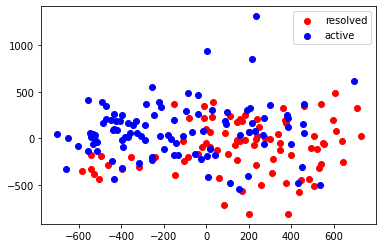

In [13]:
##plotting
print(X_2d.shape)
import matplotlib.pyplot as plt
plt.scatter(X_2d[data_labels == 0, 0], X_2d[data_labels == 0, 1], c='r', label='resolved')
plt.scatter(X_2d[data_labels == 1, 0], X_2d[data_labels == 1, 1], c='b', label='active')
plt.legend()
plt.show();

In [14]:
print(train_features.shape)
#print(y_train.shape)
import xgboost as xgb
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

eval_set = [(train_features, y_train), (test_features, y_test)]
model.fit(train_features, y_train, early_stopping_rounds = 10, eval_metric=["logloss"],
          eval_set=eval_set, verbose=False)

(148, 95744)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

[1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1
 1]
[1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0
 1]
Accuracy: 0.7368421052631579


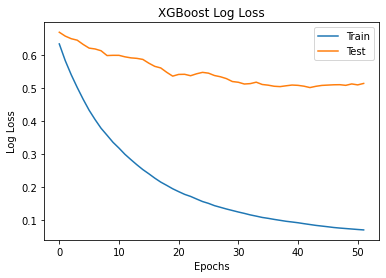

In [15]:
import matplotlib.pyplot as plt


# make predictions for test data
preds = model.predict(test_features)
print(preds)
print(y_test)
acc = np.mean(preds == y_test)
print(f"Accuracy: {acc}")

results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log Loss')
plt.show()

